In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
learning_setting_properties

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
99,gb2,500,98/99,neg_has_all_surround,unweighted


In [6]:
classifier_id = 99
classifier_properties = learning_setting_properties.loc[classifier_id]
print classifier_properties

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

model                                gb2
margin                               500
train_set_id                       98/99
neg_composition     neg_has_all_surround
sample_weighting              unweighted
Name: 99, dtype: object


In [7]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [8]:
# Load training dataset.

train_set_id_x = classifier_properties['train_set_id']
if isinstance(train_set_id_x, str) and '/' in train_set_id_x:
    # Use multiple training sets
    training_set_ids = map(int, train_set_id_x.split('/'))
    training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
else:
    # Use a single training set
    training_features, training_addresses = load_datasets([train_set_id_x], labels_to_sample=labels_to_sample)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

In [9]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [10]:
# Visualize training patches

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [11]:
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [12]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    upload_from_ec2_to_s3(clf_fp)

Tz
      Iter       Train Loss   Remaining Time 
         1           0.9214            2.82s
         2           0.7307            2.85s
         3           0.5865            2.90s
         4           0.4882            2.89s
         5           0.4157            2.88s
         6           0.3441            2.90s
         7           0.2859            2.89s
         8           0.2356            2.86s
         9           0.2022            2.81s
        10           0.1765            2.77s
        20           0.0382            2.48s
        30           0.0084            2.16s
        40           0.0019            1.85s
        50           0.0005            1.51s
        60           0.0004            1.02s
        70           0.0004            0.66s
        80           0.0004            0.38s
        90           0.0004            0.17s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Tz_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.57 seconds
Child returned 0
0.42 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.0177            2.85s
         2           0.8413            2.84s
         3           0.7352            2.77s
         4           0.6280            2.80s
         5           0.5488            2.78s
         6           0.4856            2.76s
         7           0.4274            2.74s
         8           0.3833            2.70s
         9           0.3372            2.70s
        10           0.2946            2.66s
        20           0.0930            2.37s
        30           0.0279            2.09s
        40           0.0097            1.78s
        50           0.0031            1.49s
        60           0.0010            1.19s
        70           0.0005            0.85s
        80           0.0005            0.50s
        90           0.0005            0.22s
       100           0.0005            0.00s


Fitting classifier: 2.01 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5O_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/Sp5O_clf_setting_99.dump


Child returned 0
0.37 seconds.


7n
      Iter       Train Loss   Remaining Time 
         1           0.8660            2.49s
         2           0.6657            2.84s
         3           0.5393            2.86s
         4           0.4367            2.91s
         5           0.3645            2.82s
         6           0.3028            2.81s
         7           0.2489            2.83s
         8           0.2081            2.84s
         9           0.1745            2.81s
        10           0.1486            2.78s
        20           0.0241            2.59s
        30           0.0050            2.24s
        40           0.0010            1.94s
        50           0.0003            1.52s
        60           0.0003            1.01s
        70           0.0003            0.65s
        80           0.0003            0.38s
        90           0.0003            0.17s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7n_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.55 seconds
Child returned 0
0.42 seconds.


DC
      Iter       Train Loss   Remaining Time 
         1           0.8595            4.12s
         2           0.7134            4.24s
         3           0.5853            4.27s
         4           0.4986            4.27s
         5           0.4216            4.23s
         6           0.3530            4.20s
         7           0.3057            4.16s
         8           0.2659            4.07s
         9           0.2386            3.94s
        10           0.2051            3.91s
        20           0.0501            3.56s
        30           0.0140            3.08s
        40           0.0040            2.63s
        50           0.0011            2.20s
        60           0.0004            1.67s
        70           0.0004            1.07s
        80           0.0004            0.63s
        90           0.0004            0.28s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/DC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.54 seconds
Child returned 0
0.42 seconds.


5N
      Iter       Train Loss   Remaining Time 
         1           1.0637            2.10s
         2           0.8784            2.20s
         3           0.7461            2.12s
         4           0.6339            2.08s
         5           0.5319            2.10s
         6           0.4671            2.04s
         7           0.3948            2.00s
         8           0.3433            1.95s
         9           0.3003            1.93s
        10           0.2653            1.89s
        20           0.0607            1.68s
        30           0.0147            1.47s
        40           0.0037            1.25s
        50           0.0010            1.04s
        60           0.0005            0.77s
        70           0.0005            0.50s
        80           0.0005            0.29s
        90           0.0005            0.13s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/5N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.18 seconds
Child returned 0
0.42 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           0.9291            4.20s
         2           0.7868            4.32s
         3           0.6797            4.36s
         4           0.6064            4.26s
         5           0.5207            4.28s
         6           0.4428            4.26s
         7           0.3777            4.20s
         8           0.3333            4.11s
         9           0.2921            4.09s
        10           0.2603            4.01s
        20           0.0861            3.46s
        30           0.0338            2.98s
        40           0.0121            2.55s
        50           0.0041            2.14s
        60           0.0015            1.70s
        70           0.0005            1.27s
        80           0.0005            0.76s
        90           0.0005            0.34s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RtTg_clf_setting_99.dump s3://mouseb

Fitting classifier: 3.07 seconds
Child returned 0
0.36 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           0.9465            3.61s
         2           0.7865            3.53s
         3           0.6615            3.41s
         4           0.5807            3.30s
         5           0.4961            3.23s
         6           0.4251            3.28s
         7           0.3611            3.30s
         8           0.3289            3.22s
         9           0.2801            3.20s
        10           0.2443            3.15s
        20           0.0679            2.89s
        30           0.0198            2.54s
        40           0.0064            2.17s
        50           0.0019            1.80s
        60           0.0005            1.43s
        70           0.0005            0.94s
        80           0.0005            0.55s
        90           0.0005            0.24s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Pn_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.23 seconds
Child returned 0
0.36 seconds.


10N
      Iter       Train Loss   Remaining Time 
         1           0.8020            3.53s
         2           0.6258            3.38s
         3           0.4966            3.55s
         4           0.4118            3.49s
         5           0.3414            3.53s
         6           0.2893            3.46s
         7           0.2387            3.45s
         8           0.2006            3.45s
         9           0.1670            3.44s
        10           0.1401            3.40s
        20           0.0289            3.11s
        30           0.0068            2.71s
        40           0.0016            2.33s
        50           0.0004            1.90s
        60           0.0004            1.29s
        70           0.0004            0.83s
        80           0.0004            0.48s
        90           0.0004            0.22s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/10N_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.97 seconds
Child returned 0
0.36 seconds.


LC
      Iter       Train Loss   Remaining Time 
         1           1.0764            1.24s
         2           0.8664            1.47s
         3           0.7188            1.52s
         4           0.5975            1.60s
         5           0.5080            1.59s
         6           0.4274            1.54s
         7           0.3559            1.52s
         8           0.3081            1.49s
         9           0.2590            1.49s
        10           0.2211            1.48s
        20           0.0489            1.30s
        30           0.0115            1.12s
        40           0.0028            0.97s
        50           0.0007            0.80s
        60           0.0004            0.57s
        70           0.0004            0.37s
        80           0.0004            0.21s
        90           0.0004            0.10s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 0.87 seconds
Child returned 0
0.36 seconds.


7N
      Iter       Train Loss   Remaining Time 
         1           1.1306            1.88s
         2           0.9312            2.04s
         3           0.7890            2.16s
         4           0.6827            2.08s
         5           0.5929            2.04s
         6           0.5096            1.96s
         7           0.4304            1.97s
         8           0.3759            1.95s
         9           0.3228            1.94s
        10           0.2757            1.94s
        20           0.0642            1.73s
        30           0.0177            1.51s
        40           0.0054            1.27s
        50           0.0015            1.06s
        60           0.0005            0.83s
        70           0.0005            0.53s
        80           0.0005            0.31s
        90           0.0005            0.14s
       100           0.0005            0.00s


Fitting classifier: 1.27 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7N_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/7N_clf_setting_99.dump


Child returned 0
0.36 seconds.


Amb
      Iter       Train Loss   Remaining Time 
         1           0.8827            2.86s
         2           0.6689            3.06s
         3           0.5361            3.01s
         4           0.4438            2.91s
         5           0.3567            2.96s
         6           0.2969            2.96s
         7           0.2525            2.92s
         8           0.2038            2.88s
         9           0.1660            2.88s
        10           0.1457            2.81s
        20           0.0258            2.50s
        30           0.0050            2.21s
        40           0.0009            1.91s
        50           0.0004            1.45s
        60           0.0004            0.97s
        70           0.0004            0.62s
        80           0.0004            0.36s
        90           0.0004            0.16s
       100           0.0004            0.00s


Fitting classifier: 1.49 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Amb_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/Amb_clf_setting_99.dump


Child returned 0
0.36 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           0.7912            3.37s
         2           0.5949            3.59s
         3           0.4816            3.66s
         4           0.4003            3.65s
         5           0.3389            3.64s
         6           0.2812            3.61s
         7           0.2298            3.59s
         8           0.1909            3.60s
         9           0.1697            3.49s
        10           0.1412            3.45s
        20           0.0313            3.03s
        30           0.0071            2.68s
        40           0.0017            2.32s
        50           0.0004            1.90s
        60           0.0004            1.30s
        70           0.0004            0.84s
        80           0.0004            0.49s
        90           0.0004            0.22s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/12N_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.99 seconds
Child returned 0
0.36 seconds.


RMC
      Iter       Train Loss   Remaining Time 
         1           1.1186            1.48s
         2           0.9279            1.61s
         3           0.7831            1.59s
         4           0.6687            1.60s
         5           0.5869            1.59s
         6           0.5100            1.56s
         7           0.4437            1.55s
         8           0.3850            1.53s
         9           0.3336            1.51s
        10           0.2920            1.49s
        20           0.0792            1.32s
        30           0.0248            1.14s
        40           0.0071            0.98s
        50           0.0021            0.81s
        60           0.0006            0.65s
        70           0.0005            0.43s
        80           0.0005            0.25s
        90           0.0005            0.11s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RMC_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.03 seconds
Child returned 0
0.41 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           0.8779            3.94s
         2           0.7072            4.03s
         3           0.5968            4.09s
         4           0.5008            4.04s
         5           0.4125            4.07s
         6           0.3565            4.04s
         7           0.3106            3.98s
         8           0.2677            3.95s
         9           0.2307            3.93s
        10           0.1965            3.91s
        20           0.0520            3.45s
        30           0.0147            3.00s
        40           0.0042            2.58s
        50           0.0011            2.15s
        60           0.0004            1.65s
        70           0.0004            1.06s
        80           0.0004            0.62s
        90           0.0004            0.28s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCA_clf_setting_99.dump s3://mousebra

Fitting classifier: 2.51 seconds
Child returned 0
0.41 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           0.9520            3.56s
         2           0.7597            4.13s
         3           0.6413            4.13s
         4           0.5837            3.92s
         5           0.5168            3.89s
         6           0.4390            3.92s
         7           0.3927            3.85s
         8           0.3460            3.87s
         9           0.3012            3.85s
        10           0.2695            3.80s
        20           0.0783            3.46s
        30           0.0254            3.00s
        40           0.0095            2.54s
        50           0.0033            2.11s
        60           0.0012            1.69s
        70           0.0005            1.23s
        80           0.0005            0.72s
        90           0.0005            0.32s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5I_clf_setting_99.dump s3://mouseb

Fitting classifier: 2.91 seconds
Child returned 0
0.56 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           0.9766            2.81s
         2           0.8061            3.15s
         3           0.6765            3.19s
         4           0.5708            3.20s
         5           0.4941            3.21s
         6           0.4230            3.19s
         7           0.3640            3.17s
         8           0.3201            3.16s
         9           0.2768            3.13s
        10           0.2436            3.12s
        20           0.0734            2.74s
        30           0.0239            2.38s
        40           0.0085            2.03s
        50           0.0028            1.68s
        60           0.0009            1.35s
        70           0.0005            0.96s
        80           0.0004            0.57s
        90           0.0004            0.25s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5C_clf_setting_99.dump s3://mouseb

Fitting classifier: 2.29 seconds
Child returned 0
0.41 seconds.


4N
      Iter       Train Loss   Remaining Time 
         1           0.9650            2.52s
         2           0.7588            2.82s
         3           0.6311            2.77s
         4           0.5145            2.75s
         5           0.4293            2.75s
         6           0.3591            2.78s
         7           0.3048            2.73s
         8           0.2588            2.69s
         9           0.2272            2.62s
        10           0.1939            2.58s
        20           0.0391            2.32s
        30           0.0098            2.00s
        40           0.0022            1.73s
        50           0.0005            1.43s
        60           0.0004            0.98s
        70           0.0004            0.63s
        80           0.0004            0.37s
        90           0.0004            0.16s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/4N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.50 seconds
Child returned 0
0.41 seconds.


AP
      Iter       Train Loss   Remaining Time 
         1           0.7286            2.35s
         2           0.5527            2.99s
         3           0.4292            3.22s
         4           0.3500            3.30s
         5           0.2840            3.38s
         6           0.2377            3.35s
         7           0.1904            3.35s
         8           0.1579            3.28s
         9           0.1251            3.31s
        10           0.1019            3.30s
        20           0.0137            2.98s
        30           0.0024            2.59s
        40           0.0004            2.18s
        50           0.0003            1.51s
        60           0.0003            1.01s
        70           0.0003            0.65s
        80           0.0003            0.38s
        90           0.0003            0.17s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/AP_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.55 seconds
Child returned 0
0.36 seconds.


PBG
      Iter       Train Loss   Remaining Time 
         1           0.8775            2.81s
         2           0.6798            2.87s
         3           0.5453            2.93s
         4           0.4526            2.90s
         5           0.3718            2.93s
         6           0.3079            2.93s
         7           0.2543            2.93s
         8           0.2152            2.88s
         9           0.1827            2.83s
        10           0.1522            2.81s
        20           0.0283            2.49s
        30           0.0058            2.18s
        40           0.0013            1.87s
        50           0.0004            1.51s
        60           0.0004            1.01s
        70           0.0004            0.65s
        80           0.0004            0.38s
        90           0.0004            0.17s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/PBG_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.55 seconds
Child returned 0
0.36 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           1.0048            2.81s
         2           0.8405            2.92s
         3           0.7029            2.99s
         4           0.5871            3.03s
         5           0.5022            3.02s
         6           0.4313            3.00s
         7           0.3690            2.96s
         8           0.3236            2.94s
         9           0.2772            2.92s
        10           0.2391            2.90s
        20           0.0628            2.58s
        30           0.0171            2.26s
        40           0.0047            1.94s
        50           0.0014            1.61s
        60           0.0005            1.25s
        70           0.0005            0.82s
        80           0.0005            0.48s
        90           0.0005            0.21s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LRt_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.94 seconds
Child returned 0
0.41 seconds.


IC
      Iter       Train Loss   Remaining Time 
         1           1.0709            2.94s
         2           0.9205            2.91s
         3           0.7918            2.86s
         4           0.6812            2.84s
         5           0.6088            2.80s
         6           0.5319            2.78s
         7           0.4763            2.74s
         8           0.4203            2.69s
         9           0.3779            2.65s
        10           0.3290            2.63s
        20           0.1071            2.32s
        30           0.0354            2.02s
        40           0.0121            1.73s
        50           0.0041            1.45s
        60           0.0013            1.16s
        70           0.0005            0.86s
        80           0.0005            0.51s
        90           0.0005            0.23s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/IC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.06 seconds
Child returned 0
0.36 seconds.


VLL
      Iter       Train Loss   Remaining Time 
         1           0.9976            2.63s
         2           0.8113            2.61s
         3           0.6494            2.62s
         4           0.5406            2.58s
         5           0.4445            2.57s
         6           0.3747            2.56s
         7           0.3132            2.54s
         8           0.2748            2.48s
         9           0.2324            2.46s
        10           0.1982            2.43s
        20           0.0410            2.14s
        30           0.0096            1.86s
        40           0.0022            1.60s
        50           0.0005            1.30s
        60           0.0004            0.89s
        70           0.0004            0.58s
        80           0.0004            0.34s
        90           0.0004            0.15s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VLL_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.37 seconds
Child returned 0
0.41 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           0.9044            3.78s
         2           0.7633            3.82s
         3           0.6250            4.01s
         4           0.5360            3.93s
         5           0.4543            3.95s
         6           0.3978            3.88s
         7           0.3440            3.83s
         8           0.2986            3.78s
         9           0.2640            3.80s
        10           0.2304            3.75s
        20           0.0731            3.28s
        30           0.0233            2.87s
        40           0.0077            2.46s
        50           0.0029            2.03s
        60           0.0009            1.62s
        70           0.0004            1.15s
        80           0.0004            0.67s
        90           0.0004            0.30s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCP_clf_setting_99.dump s3://mousebra

Fitting classifier: 2.73 seconds
Child returned 0
0.41 seconds.


SNC
      Iter       Train Loss   Remaining Time 
         1           1.0127            2.57s
         2           0.8249            2.66s
         3           0.6645            2.69s
         4           0.5617            2.72s
         5           0.4764            2.68s
         6           0.4094            2.65s
         7           0.3612            2.62s
         8           0.3166            2.55s
         9           0.2762            2.50s
        10           0.2393            2.49s
        20           0.0625            2.26s
        30           0.0176            1.98s
        40           0.0047            1.70s
        50           0.0014            1.41s
        60           0.0005            1.10s
        70           0.0005            0.71s
        80           0.0005            0.42s
        90           0.0005            0.19s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNC_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.69 seconds
Child returned 0
0.41 seconds.


6N
      Iter       Train Loss   Remaining Time 
         1           0.9218            2.63s
         2           0.7018            2.85s
         3           0.5570            2.88s
         4           0.4625            2.82s
         5           0.3828            2.80s
         6           0.3059            2.77s
         7           0.2518            2.76s
         8           0.2139            2.69s
         9           0.1759            2.70s
        10           0.1498            2.66s
        20           0.0269            2.37s
        30           0.0054            2.08s
        40           0.0011            1.78s
        50           0.0004            1.36s
        60           0.0004            0.91s
        70           0.0004            0.59s
        80           0.0004            0.34s
        90           0.0004            0.15s
       100           0.0004            0.00s


Fitting classifier: 1.39 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/6N_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/6N_clf_setting_99.dump


Child returned 0
0.41 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           0.7999            4.15s
         2           0.6607            4.41s
         3           0.5532            4.30s
         4           0.4665            4.25s
         5           0.3909            4.32s
         6           0.3313            4.37s
         7           0.2886            4.28s
         8           0.2571            4.17s
         9           0.2204            4.17s
        10           0.1877            4.17s
        20           0.0561            3.65s
        30           0.0210            3.12s
        40           0.0064            2.69s
        50           0.0023            2.23s
        60           0.0008            1.78s
        70           0.0004            1.27s
        80           0.0004            0.74s
        90           0.0004            0.33s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNR_clf_setting_99.dump s3://mousebra

Fitting classifier: 3.00 seconds
Child returned 0
0.36 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.0485            3.09s
         2           0.9059            3.02s
         3           0.7961            2.90s
         4           0.6944            2.89s
         5           0.6202            2.80s
         6           0.5470            2.76s
         7           0.4869            2.71s
         8           0.4305            2.70s
         9           0.3761            2.67s
        10           0.3429            2.62s
        20           0.1131            2.35s
        30           0.0384            2.04s
        40           0.0153            1.73s
        50           0.0056            1.44s
        60           0.0021            1.16s
        70           0.0008            0.86s
        80           0.0005            0.53s
        90           0.0005            0.24s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.16 seconds
Child returned 0
0.41 seconds.


3N
      Iter       Train Loss   Remaining Time 
         1           1.0229            2.80s
         2           0.8617            2.85s
         3           0.7249            2.87s
         4           0.6155            2.85s
         5           0.5126            2.91s
         6           0.4442            2.93s
         7           0.3900            2.88s
         8           0.3361            2.86s
         9           0.2921            2.82s
        10           0.2612            2.77s
        20           0.0794            2.35s
        30           0.0251            2.05s
        40           0.0072            1.76s
        50           0.0022            1.47s
        60           0.0007            1.17s
        70           0.0005            0.79s
        80           0.0005            0.46s
        90           0.0005            0.20s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/3N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.86 seconds
Child returned 0
0.36 seconds.


# Load pre-computed classifiers

In [ ]:
classifier_id = 99

In [17]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump


Child returned 0
Child returned 1
0.44 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump


Child returned 1
0.35 seconds.
Classifier for outerContour is not found.


In [14]:
margin = 500
neg_composition = 'neg_has_all_surround'

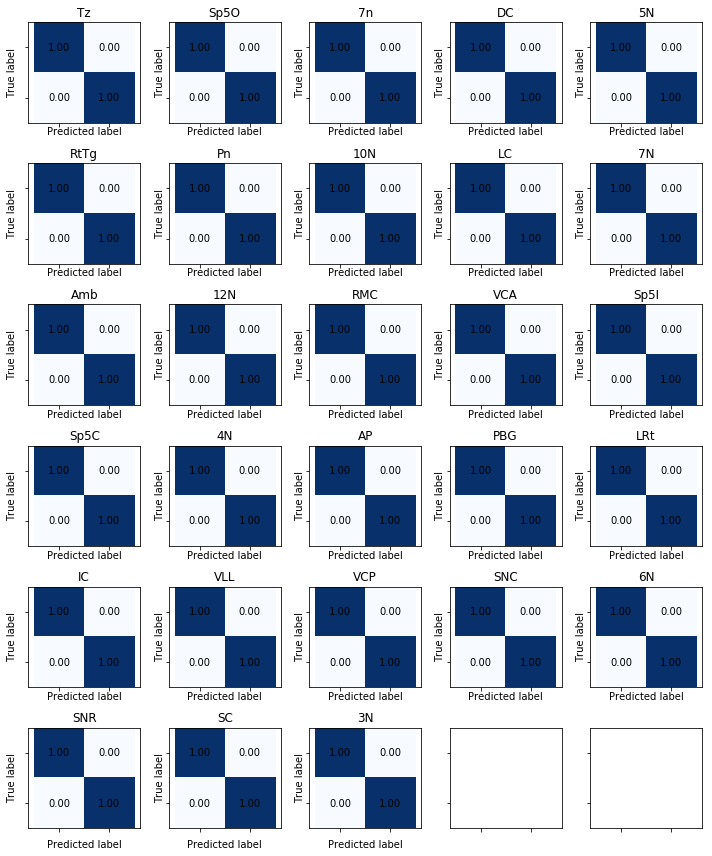

In [15]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [16]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.999782360074


In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg